In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import zipfile

def load_data(filename : str, ds : str) -> pd.DataFrame:

    with zipfile.ZipFile(filename, 'r') as zipFile:

        # Obtain a list of all files in the zip archive
        fileList = zipFile.namelist()

        # Filter only files with name in db argument ending with .xls
        targetedFileNames = [file for file in fileList if file.endswith(f'{ds}.xls')]

        df = []

        # Obtain dataframe from each file and append it to the list
        for file in targetedFileNames:
            with zipFile.open(file) as f:
                df.extend(pd.read_html(f, encoding="cp1250"))


        # Concatenate all dataframes into one (ignore index for not using index values from original dataframes)
        df = pd.concat(df, ignore_index=True)

        # Drop unnamed columns containing NaN values
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        return df
# Ukol 2: zpracovani dat


def parse_data(df: pd.DataFrame, verbose: bool = False) -> pd.DataFrame:

    regions = {
        0: "PHA", 1: "STC", 2: "JHC", 3: "PLK",
        4: "ULK", 5: "HKK", 6: "JHM", 7: "MSK",
        14: "OLK", 15: "ZLK", 16: "VYS", 17: "PAK",
        18: "LBK", 19: "KVK"
    }

    newDf = df.copy()
    newDf["date"] = pd.to_datetime(newDf["p2a"], format="%d.%m.%Y", errors="coerce")
    newDf["region"] = newDf["p4a"].map(regions)
    newDf = newDf.drop_duplicates(subset='p1', keep=False)

    if(verbose):
        print(f'new_size={(newDf.memory_usage(deep=True).sum() / (1000 * 1000)):.1f} MB')
    return newDf

In [2]:
df = load_data("data_23_24.zip", "nehody")
df2 = parse_data(df, True)

new_size=68.3 MB


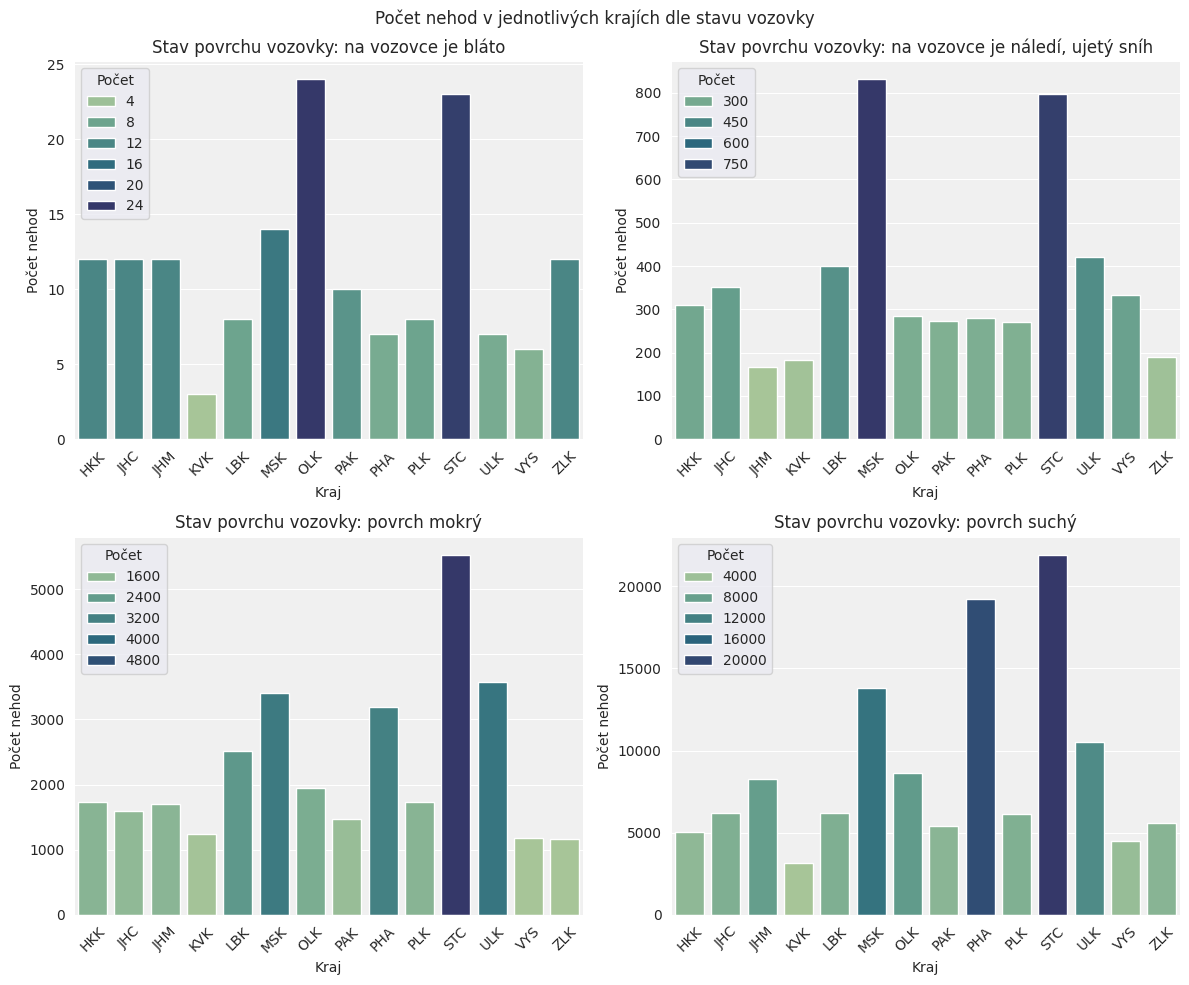

In [132]:
def plot_state(df: pd.DataFrame, fig_location: str = None,
                    show_figure: bool = False):

    roadStates = {
        1: "povrch suchý",
        2: "povrch suchý",
        3: "povrch mokrý",
        4: "na vozovce je bláto",
        5: "na vozovce je náledí, ujetý sníh",
        6: "na vozovce je náledí, ujetý sníh",
    }

    df["roadStates"] = df["p16"].map(roadStates)
    roadsWithRegions = df.groupby(["region", "roadStates"]).size().reset_index(name="count")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    

    fig.suptitle("Počet nehod v jednotlivých krajích dle stavu vozovky")

    roadStateList = roadsWithRegions["roadStates"].unique()
    for i, axe in enumerate(axes):

        currentRoadState = roadsWithRegions[roadsWithRegions["roadStates"] == roadStateList[i]]
        sns.barplot(data=currentRoadState, x="region", y="count", ax=axe, palette="crest", hue="count")
        sns.set_style("darkgrid")

        axe.legend(title="Počet", loc="upper left")
        axe.set_facecolor('#f0f0f0')
        axe.set_title(f'Stav povrchu vozovky: {roadStateList[i]}')
        axe.tick_params(axis='x', rotation=45)
        axe.set_xlabel("Kraj")
        axe.set_ylabel("Počet nehod")

    plt.tight_layout()

    if(fig_location):
        plt.savefig(fig_location)
    if(show_figure):
        plt.show()
    


plot_state(df2, "01_state.png")

In [ ]:
def plot_alcohol(df: pd.DataFrame, df_consequences : pd.DataFrame, 
                 fig_location: str = None, show_figure: bool = False):
    
    
    